In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.covariance import MinCovDet
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import seaborn as sns



# Load and preprocess your dataset


In [ ]:
data = pd.read_csv(r"E:\Feature Engineering\archive\ecommerce_customer_data_custom_ratios.csv")
data.dropna(inplace=True)
data['Product Category'] = pd.factorize(data['Product Category'])[0]
data['Payment Method'] = pd.factorize(data['Payment Method'])[0]
data['Gender'] = pd.factorize(data['Gender'])[0]



# Normalize the relevant columns


In [ ]:
numeric_columns = ['Product Price', 'Quantity', 'Total Purchase Amount', 'Customer Age', 'Returns']
data_normalized = data[numeric_columns].apply(zscore)



# Anomaly detection methods
# Z-score


In [ ]:
threshold = 3
data['Z_Score_Anomaly'] = (np.abs(data_normalized) > threshold).any(axis=1

)

# Mahalanobis


In [ ]:
cov = MinCovDet().fit(data_normalized)
mahal_distances = cov.mahalanobis(data_normalized)
threshold_mahal = np.percentile(mahal_distances, 95)
data['Mahalanobis_Anomaly'] = mahal_distances > threshold_mahal



# LOF


In [ ]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
data['LOF_Anomaly'] = lof.fit_predict(data_normalized) == -1



# Isolation Forest


In [ ]:
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
data['IsolationForest_Anomaly'] = isolation_forest.fit_predict(data_normalized) == -1



# One-Class SVM


In [ ]:
one_class_svm = OneClassSVM(nu=0.05, gamma='auto')
data['OneClassSVM_Anomaly'] = one_class_svm.fit_predict(data_normalized) == -1


C:\Users\sgnav\AppData\Local\Temp\ipykernel_13852\3067574784.py:52: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  ax.legend(handles, labels, title='Anomaly', loc='upper right', labels=['Normal', 'Anomaly'], fontsize=12)
C:\Users\sgnav\AppData\Local\Temp\ipykernel_13852\3067574784.py:52: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  ax.legend(handles, labels, title='Anomaly', loc='upper right', labels=['Normal', 'Anomaly'], fontsize=12)
C:\Users\sgnav\AppData\Local\Temp\ipykernel_13852\3067574784.py:52: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  ax.legend(handles, labels, title='Anomaly', loc='upper right',

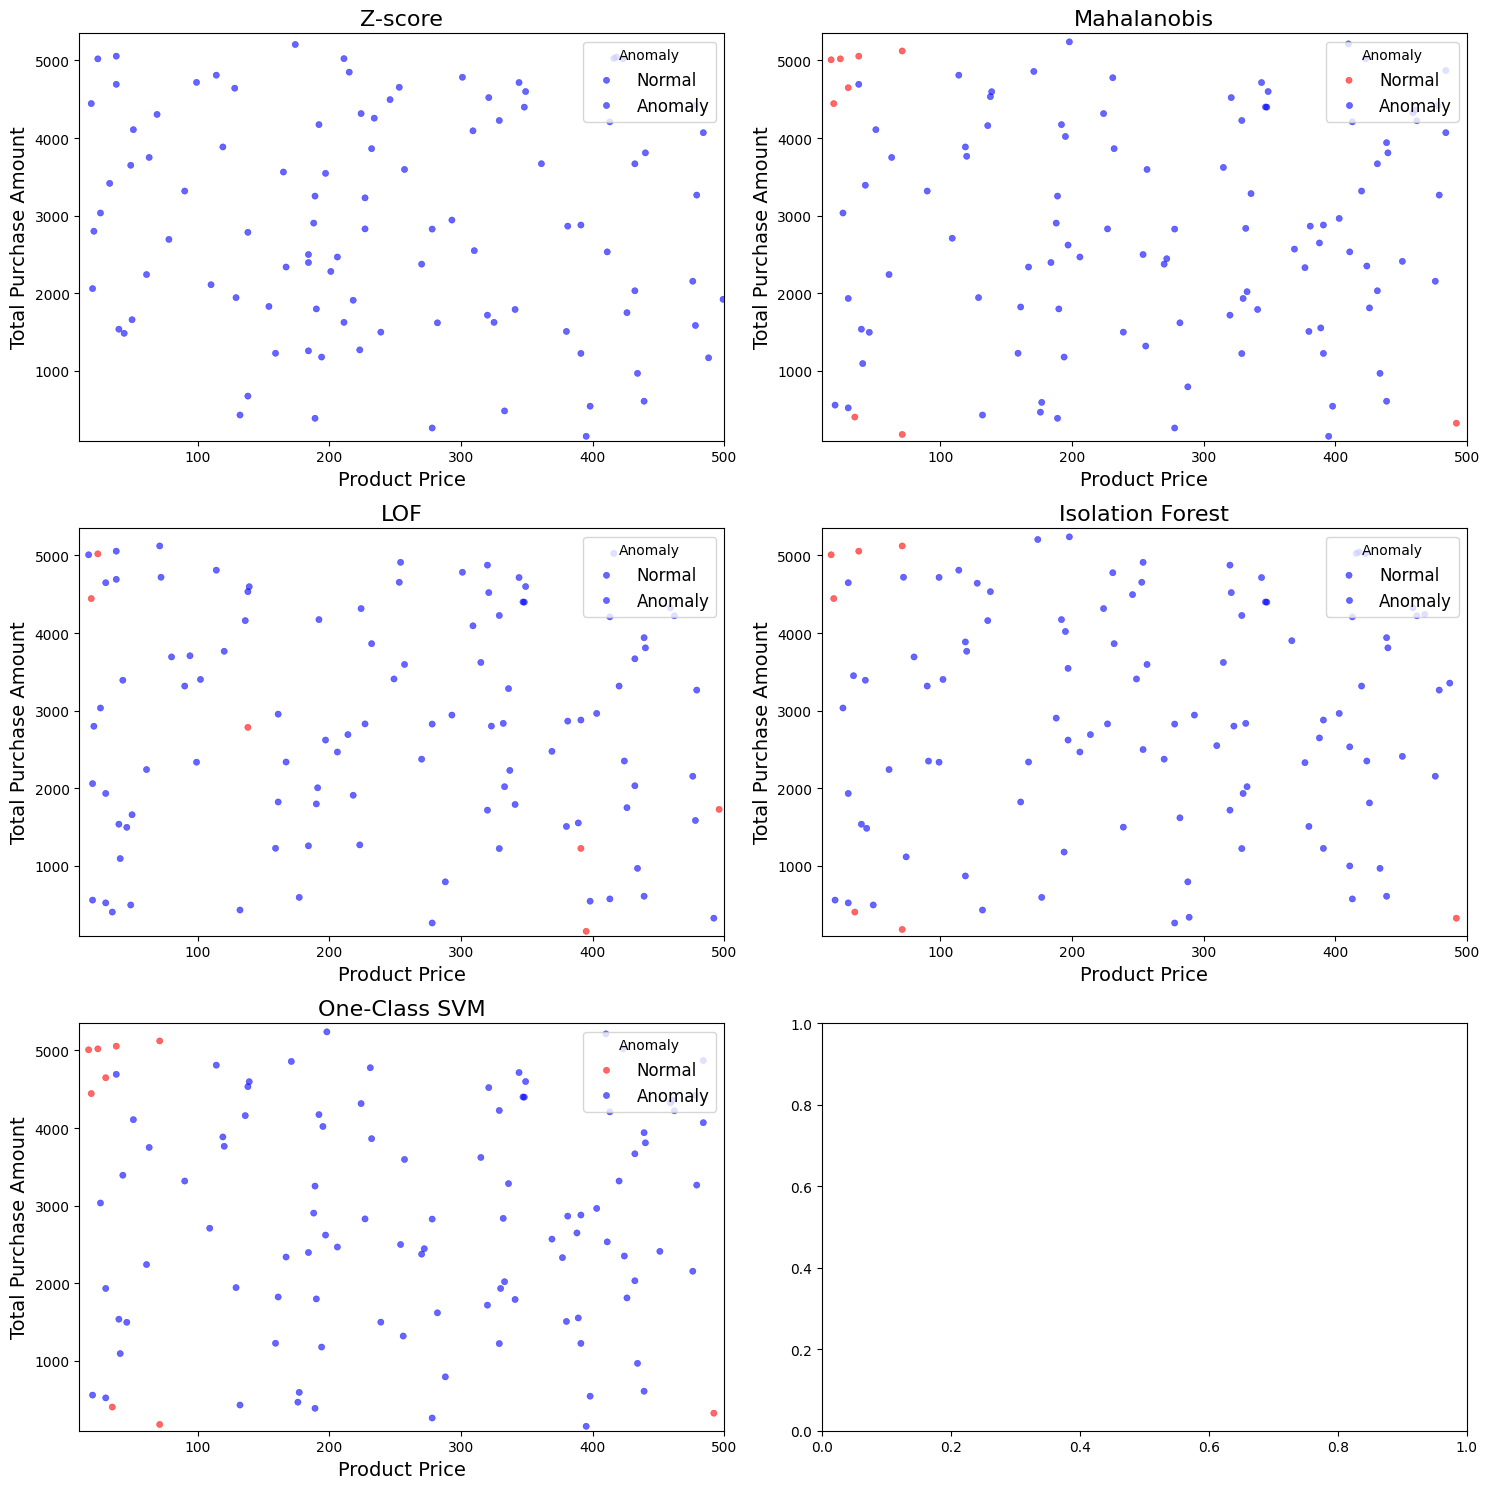

In [4]:
# Visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
methods = [
    data['Z_Score_Anomaly'], 
    data['Mahalanobis_Anomaly'], 
    data['LOF_Anomaly'], 
    data['IsolationForest_Anomaly'], 
    data['OneClassSVM_Anomaly']
]
titles = ["Z-score", "Mahalanobis", "LOF", "Isolation Forest", "One-Class SVM"]

anomaly_color = 'red'
normal_color = 'blue'

# Sample a smaller subset for better visualization
data_sample = data.sample(n=200, random_state=1)  # Limit to a fixed number of points

for ax, anomalies, title in zip(axes.flat, methods, titles):
    # Create a boolean mask for anomalies in the sample
    anomaly_mask = anomalies[data_sample.index]
    
    # Sample normal points from the data sample
    normal_sample = data_sample[~anomaly_mask].sample(min(100, data_sample[~anomaly_mask].shape[0]), random_state=1)  # Limit normal samples to 100
    
    # Combine normal sample with the anomalies
    if title == "Z-score":
        # For Z-score, we want to show both normal and anomaly points distinctly
        combined_sample = pd.concat([normal_sample, data_sample[anomaly_mask]])
        hue_data = combined_sample['Z_Score_Anomaly']
    else:
        combined_sample = pd.concat([normal_sample, data_sample[anomaly_mask]])
        hue_data = anomalies[data_sample.index]
    
    # Plotting
    sns.scatterplot(data=combined_sample, 
                    x='Product Price', 
                    y='Total Purchase Amount', 
                    hue=hue_data, 
                    palette={True: anomaly_color, False: normal_color}, 
                    ax=ax, alpha=0.6, edgecolor=None, s=20)  # Smaller point size and adjusted alpha
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Product Price", fontsize=14)
    ax.set_ylabel("Total Purchase Amount", fontsize=14)

    # Set axis limits if necessary (adjust based on your data)
    ax.set_xlim(data['Product Price'].min(), data['Product Price'].max())
    ax.set_ylim(data['Total Purchase Amount'].min(), data['Total Purchase Amount'].max())
    
    # Set legend in the top right position for each subplot
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title='Anomaly', loc='upper right', labels=['Normal', 'Anomaly'], fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()